## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

In [124]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm
from torch import nn

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

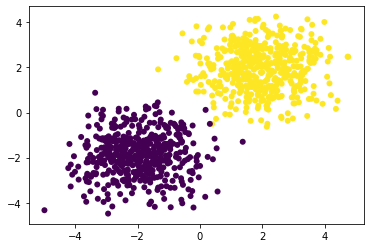

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 50
batch_size = 1000

In [3]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

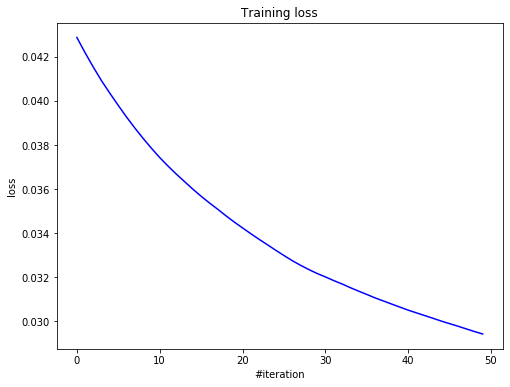

Current loss: 0.029427


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [213]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [214]:
# Your code goes here. ################################################
def one_hot(array):
    n_unique = np.unique(array).shape[0]
    new_array = np.zeros((n_unique, array.shape[0]))
    for i in range(array.shape[0]):
        vec = np.zeros((n_unique))
        vec[array[i]] = 1
        new_array[:,i] = vec
    return new_array
    
y_train = one_hot(y_train).T
y_val = one_hot(y_val).T
y_test = one_hot(y_test).T

#Делаем из двумерной картинки одномерный массив
X_train = np.array([X_train[i,:,:].flatten() for i in range(X_train.shape[0])])
X_test = np.array([X_test[i,:,:].flatten() for i in range(X_test.shape[0])])
X_val = np.array([X_val[i,:,:].flatten() for i in range(X_val.shape[0])])

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [6]:
X_train.shape

(50000, 784)

In [122]:
# def get_batch(dataset, batch_size):
#     X, Y = dataset
#     n_samples = X.shape[0]
        
#     # Shuffle at the start of epoch
#     indices = np.arange(n_samples)
#     np.random.shuffle(indices)
#     start = np.random.randint(0, n_samples)
#     end = min(start + batch_size, n_samples)
#     batch_idx = indices[start:end]
    
#     return X[batch_idx], Y[batch_idx]

In [8]:
def lin_layer(n_in, n_out, activation):
    nn = Sequential()
    nn.add(Linear(n_in, n_out))
    nn.add(activation)
    nn.add(LogSoftMax())
    return nn

def train_loop(n_epoch, batch_size, net, criterion, optimizer, optimizer_config):
    optimizer_state = {}
    loss_history = []
    for i in tqdm(range(n_epoch)):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

            net.zeroGradParameters()     

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            optimizer(net.getParameters(), 
                        net.getGradParameters(), 
                        optimizer_config,
                        optimizer_state)
        
            loss_history.append(loss)
            
            
    return loss_history

# ReLU

In [134]:
relu = lin_layer(784, 10, ReLU())
criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
n_epoch = 20
batch_size = 1000
optimizer = sgd_momentum
relu_loss = train_loop(n_epoch, batch_size, relu, criterion, optimizer, optimizer_config)

100%|██████████| 20/20 [01:17<00:00,  3.89s/it]


# ELU

In [130]:
elu = lin_layer(784, 10, ELU())
criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
n_epoch = 20
batch_size = 1000
optimizer = sgd_momentum
elu_loss = train_loop(n_epoch, batch_size, elu, criterion, optimizer, optimizer_config)

100%|██████████| 20/20 [01:32<00:00,  4.63s/it]


# Leaky ReLU

In [131]:
leak_relu = lin_layer(784, 10, LeakyReLU())
criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
n_epoch = 20
batch_size = 1000
optimizer = sgd_momentum
leak_relu_loss = train_loop(n_epoch, batch_size, leak_relu, criterion, optimizer, optimizer_config)

100%|██████████| 20/20 [01:21<00:00,  4.06s/it]


# SoftPlus

In [132]:
softplus = lin_layer(784, 10, SoftPlus())
criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
n_epoch = 20
batch_size = 1000
optimizer = sgd_momentum
softplus_loss = train_loop(n_epoch, batch_size, softplus, criterion, optimizer, optimizer_config)

100%|██████████| 20/20 [01:17<00:00,  3.85s/it]


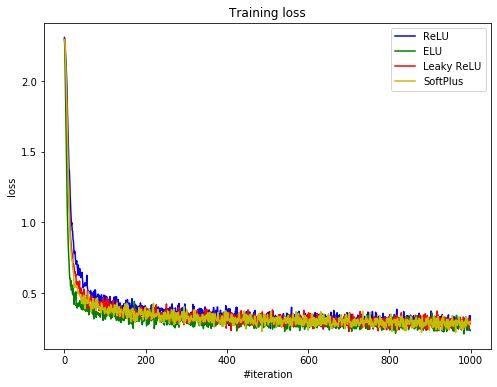

In [135]:
plt.figure(figsize=(8, 6))
        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(relu_loss, 'b')
plt.plot(elu_loss, 'g')
plt.plot(leak_relu_loss, 'r')
plt.plot(softplus_loss, 'y')
plt.legend(['ReLU', 'ELU', 'Leaky ReLU', 'SoftPlus'])
plt.show()

#### Из графика видно, что быстрее всех сходятся ELU и SoftPlus, а второе место между собой делят ReLU и Leaky ReLU.

In [80]:
relu_bnorm = Sequential()
relu_bnorm.add(Linear(784, 10))
bn = BatchNormalization()
bn.moving_mean = np.zeros((batch_size, 10))
bn.moving_variance = np.zeros((batch_size, 10))
relu_bnorm.add(bn)
relu_bnorm.add(ChannelwiseScaling(10))
relu_bnorm.add(ReLU())
relu_bnorm.add(LogSoftMax())

In [81]:
criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
n_epoch = 20
batch_size = 1000
optimizer = sgd_momentum
relu_bnorm_loss = train_loop(n_epoch, batch_size, relu_bnorm, criterion, optimizer, optimizer_config)

100%|██████████| 20/20 [01:32<00:00,  4.65s/it]


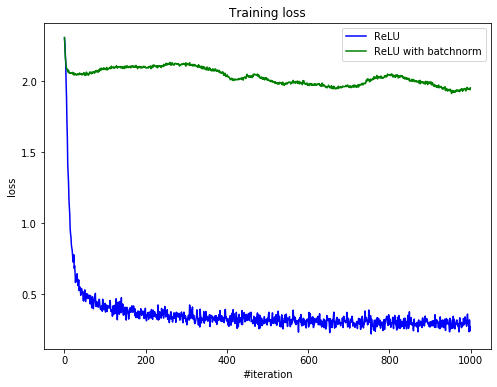

In [82]:
plt.figure(figsize=(8, 6))
        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(relu_loss, 'b')
plt.plot(relu_bnorm_loss, 'g')
plt.legend(['ReLU', 'ReLU with batchnorm'])
plt.show()

#### Не исключаю возможности, что я где-то допустила ошибку, но батчнорм лишь ухудшает итоговый loss, что можно увидеть на графике. Если же убрать слой ChannelWiseScaling, то loss получится около 0,5 как и положено. Природу этого явления мне выяснить не удалось...

In [89]:
relu_adam = lin_layer(784, 10, ReLU())
criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate':1e-2, 'beta1':0.9, 'beta2':0.999, 'epsilon':1e-8}
n_epoch = 20
batch_size = 1000
optimizer = adam_optimizer
relu_adam_loss = train_loop(n_epoch, batch_size, relu_adam, criterion, optimizer, optimizer_config)

100%|██████████| 20/20 [01:26<00:00,  4.33s/it]


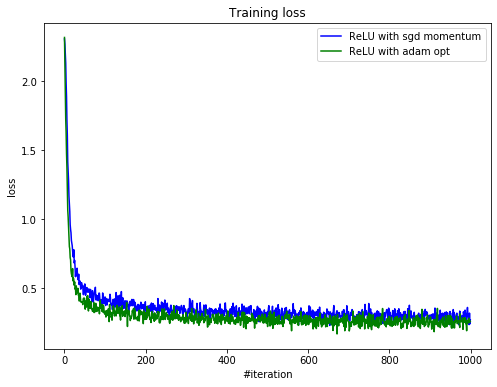

In [90]:
plt.figure(figsize=(8, 6))
        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(relu_loss, 'b')
plt.plot(relu_adam_loss, 'g')
plt.legend(['ReLU with sgd momentum', 'ReLU with adam opt'])
plt.show()

#### Из графика видно, что adam optimizer сходится немного быстрее, чем sgd при выбранных параметрах.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [102]:
best_nn = Sequential()
best_nn.add(Linear(784,300))
best_nn.add(Dropout(p=0.4))
best_nn.add(ReLU())
best_nn.add(Linear(300,10))
best_nn.add(LogSoftMax())

In [103]:
criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
n_epoch = 20
batch_size = 1000
optimizer = sgd_momentum
best_loss = train_loop(n_epoch, batch_size, best_nn, criterion, optimizer, optimizer_config)

100%|██████████| 20/20 [35:29<00:00, 106.48s/it]


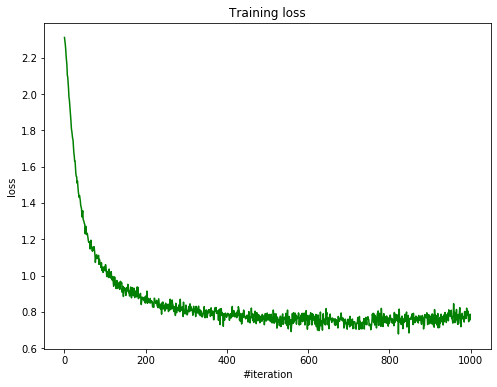

In [117]:
plt.figure(figsize=(8, 6))
        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(best_loss, 'g')
plt.show()

Print here your accuracy on test set. It should be around 90%.

In [179]:
def validation_loop(n_epoch, batch_size, net, criterion):
    net.evaluate()
    loss_history = []
    accuracy = []
    for i in tqdm(range(n_epoch)):
        for x_batch, y_batch in get_batches((X_val, y_val), batch_size):

            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
     
            loss_history.append(loss)
            predictions = np.exp(predictions)
            pred_labels = np.argmax(predictions, axis=1)
            accuracy.append(np.sum(np.argmax(y_batch, axis=1) == pred_labels) / len(y_batch))
            
    return loss_history, accuracy

In [181]:
criterion = ClassNLLCriterion()

In [182]:
relu_loss, relu_acc = validation_loop(10, 1000, relu, criterion)

100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


In [183]:
elu_loss, elu_acc = validation_loop(10, 1000, elu, criterion)

100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


In [184]:
lear_relu_loss, leak_relu_acc = validation_loop(10, 1000, leak_relu, criterion)

100%|██████████| 10/10 [00:01<00:00,  7.61it/s]


In [185]:
softplus_loss, softplus_acc = validation_loop(10, 1000, softplus, criterion)

100%|██████████| 10/10 [00:01<00:00,  7.20it/s]


In [186]:
best_loss, best_acc = validation_loop(10, 1000, best_nn, criterion)

100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


In [192]:
print('Validation accuracy for relu net: ', '%.3f' %np.mean(relu_acc))
print('Validation accuracy for elu net: ', '%.3f' %np.mean(elu_acc))
print('Validation accuracy for leaky relu net: ', '%.3f' %np.mean(leak_relu_acc))
print('Validation accuracy for softplus net: ', '%.3f' %np.mean(softplus_acc))
print('Validation accuracy for last net: ', '%.3f' %np.mean(best_acc))

Validation accuracy for relu net:  0.922
Validation accuracy for elu net:  0.926
Validation accuracy for leaky relu net:  0.922
Validation accuracy for softplus net:  0.923
Validation accuracy for last net:  0.867


### Выберем ELU и сравним с последней сетью посложнее

In [143]:
best_test_predictions_ = best_nn.forward(X_test)
elu_test_predictions = elu.forward(X_test)

best_test_predictions = np.exp(test_predictions)
best_test_pred_labels = np.argmax(test_predictions, axis=1)
best_test_acc = np.sum(np.argmax(y_test, axis=1) == test_pred_labels) / len(y_test)

elu_test_predictions = np.exp(elu_test_predictions)
elu_test_pred_labels = np.argmax(elu_test_predictions, axis=1)
elu_test_acc = np.sum(np.argmax(y_test, axis=1) == elu_test_pred_labels) / len(y_test)

print('Test accuracy for elu net: ', relu_test_acc)
print('Test accuracy for last net: ', best_test_acc)

Test accuracy for elu net:  0.9179
Test accuracy for last net:  0.8598


# Иногда проще значит лучше...

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [147]:
from torch.optim import SGD

In [175]:
torch_nn = nn.Sequential(nn.Linear(784,300),
                         nn.Dropout(p=0.4),
                         nn.ReLU(),
                         nn.Linear(300,10),
                         nn.LogSoftmax(dim=1))
optimizer = SGD(torch_nn.parameters(), lr=1e-1)
criterion = nn.NLLLoss()

In [176]:
n_epochs = 15
batch_size = 1000
loss_hist = []
for i in tqdm(range(n_epochs)):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        x_batch = torch.from_numpy(x_batch)
        y_batch = np.argmax(y_batch, axis=1)
        y_batch = torch.from_numpy(y_batch).long()
        
        torch_nn.train()
        optimizer.zero_grad()

        preds = torch_nn(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        
        loss_hist.append(loss)
        

100%|██████████| 15/15 [00:25<00:00,  1.70s/it]


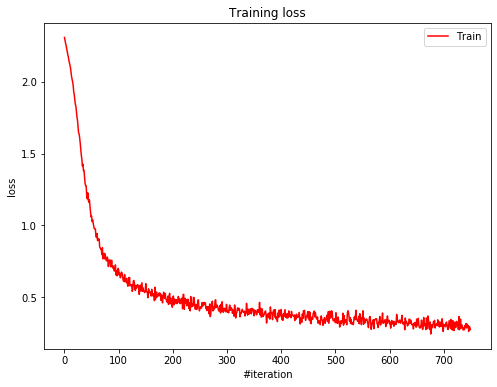

In [178]:
plt.figure(figsize=(8, 6))
        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_hist, 'r')
plt.legend(['Train'])
plt.show()

In [204]:
val_acc = []
for i in tqdm(range(n_epochs)):
    for x_batch_val, y_batch_val in get_batches((X_val, y_val), batch_size):
        x_batch_val = torch.from_numpy(x_batch_val)
        y_batch_val = np.argmax(y_batch_val, axis=1)
        
        torch_nn.train(False)

        preds_val = torch_nn(x_batch_val).detach().numpy()
        
        preds_val = np.exp(preds_val)
        preds_val_labels = np.argmax(preds_val, axis=1)
        val_acc.append(np.sum(y_batch_val == preds_val_labels) / len(y_batch_val))
        

100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


In [205]:
print('Validation accuracy for torch net:', np.mean(val_acc))

Validation accuracy for torch net: 0.9312


In [215]:
test_acc = []
torch_nn.train(False)

X_test = torch.from_numpy(X_test)
y_test = np.argmax(y_test, axis=1)

preds_test = torch_nn(X_test).detach().numpy()

preds_test = np.exp(preds_test)
preds_test_labels = np.argmax(preds_test, axis=1)
test_acc = np.sum(y_test == preds_test_labels) / len(y_test)

In [216]:
print('Test accuracy for torch net: ', test_acc)

Test accuracy for torch net:  0.9287


## Вывод: точность сетей одинаковой архитектуры, но написанных по-разному: собственноручно и с помощью библиотеки torch отличаются на 7%. Кроме того, библиотечная сеть работает гораздо быстрее собственной.  